<h1 style="text-align: center;" class="list-group-item list-group-item-action active">Bayesian Analysis - Predicting Hubble Constant from Supernova Data</h1>

We wish to investigate the hubble constant (hubble_const) which together with the density of matter content (omega_m) of the universe determines the observed rate of expansion of the universe. Hubble constant drives expansion while a higher density of matter slows this expansion down via gravity.

We will use supernova as 'standard candles' these allow us to judge distances in the universe. Their true brightness is constant (nearly so) and so their apparent brightness in the night sky should be a simple function of the distance to the object. In turn we may infer their distance using their observed redshift i.e. the stretching of the wavelength of the light coming from the object (as compared to their standard spectrum). This stretching is due to their recessional velocity thanks to the expansion of space and so depends on our key paramters we wish to investigate: hubble_const and omega_m.

**We will construct a theoretical model of the relationship between redshift of a supernova and its apparent brightness involving parameters h and omega_m.**

**We will then compare this model to our data within a Bayesian framework.**

**On the way we will use Bayes theorem of course and Markov Chain Monte Carlo sampling via the Metropolis-Hastings algorithm.**

In this notebook we will construct sampling algorithms ourselves rather than relying on existing packages. This is to ensure we fully understand the methods.

<h1 style="text-align: center;" class="list-group-item list-group-item-action active">Section Links</h1>
<a class="list-group-item list-group-item-action" data-toggle="list" href = "#1" role="tab" aria-controls="settings">Plotting Data and Theoretical Curves<span class="badge badge-primary badge-pill">1</span></a>

<a class="list-group-item list-group-item-action" data-toggle="list" href = "#2" role="tab" aria-controls="settings">Bayesian Parameter Estimation<span class="badge badge-primary badge-pill">2</span></a>

<a class="list-group-item list-group-item-action" data-toggle="list" href = "#2" role="tab" aria-controls="settings">MCMC metropolis algorithm<span class="badge badge-primary badge-pill">3</span></a>

<a class="list-group-item list-group-item-action" data-toggle="list" href = "#2" role="tab" aria-controls="settings">Summary Stats and Parameter Estimation<span class="badge badge-primary badge-pill">4</span></a>

<a class="list-group-item list-group-item-action" data-toggle="list" href = "#2" role="tab" aria-controls="settings">Trying a Different Prior<span class="badge badge-primary badge-pill">5</span></a>


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('../code'))
if module_path not in sys.path:
    sys.path.insert(0, module_path)

print(f"Current working directory: {os.getcwd()}")
print(f"Source code is in system path @ {sys.path[0]}")

import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Current working directory: /Users/joshgowdy/GitHub/bayesian-supernova-analysis/notebooks
Source code is in system path @ /Users/joshgowdy/GitHub/bayesian-supernova-analysis/code


In [2]:
from loadin import load_supernova_data, load_cov_data
from model import supernova_curves, dist_mod_func, simulate_supernovae, model_log_likelihood, logflatprior, loggaussprior, empirical_log_posterior
from sampling import supernova_metropolis_hastings, simple_grad_log_posterior, hamiltonian_monte_carlo

## <h1  style="text-align: center" class="list-group-item list-group-item-action active">Plotting Data and Comparing to Curves from Theoretical Model</h1><a id = "1" ></a>

We first load supernova data "supernova_data_file_jla_mub.txt" file which includes redshift, z, and 'brightness' i.e. distance modulus, mu, for 700 supernova resampled into 31 bins.

In [3]:
# load in test    
supernova_df=load_supernova_data("../data/supernova_data_file_jla_mub.txt")
supernova_df.head()

,redshift,distance modulus
0,0.010,32.953887
1,0.012,33.879003
2,0.014,33.842141
3,0.016,34.118567
4,0.019,34.593446


#### Theoretical Model for the observed Redshift of astronomical objects at Various Distances

To construct the model we define intermediary functions (see explanatory pdf supernove-project-notes.pdf and model.py script) and then define a function which maps redshifts z to the theoretical value of the distance modulus mu.

We then plot theoretical curves. The model depends on the expansion rate of the universe which in turn
depends on the actual matter content of the universe (the matter densities omega_m) and hubbles constant (hubble_const) driving the expansion. We plot also the data,

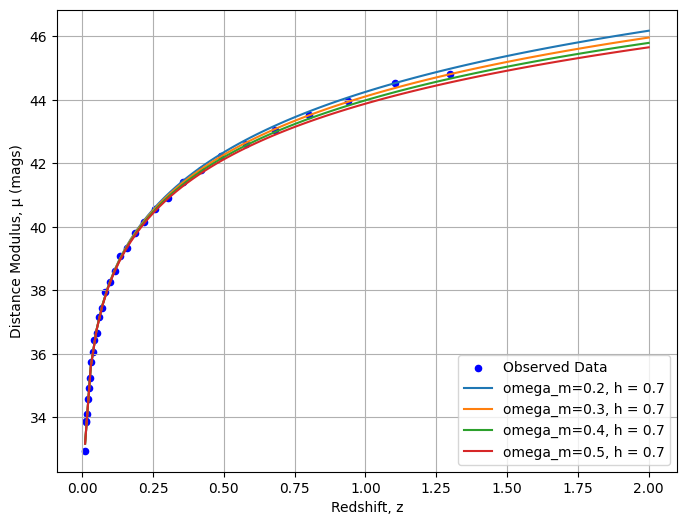

In [4]:
# plot data along with theoretical predictions
hubble_vals = [0.7]
omega_m_vals = [0.2, 0.3, 0.4, 0.5]
theoretical_df=supernova_curves(omega_m_vals, hubble_vals)

fig, ax = plt.subplots(figsize=(8, 6))
    
# scatterplt of actual supernova data
supernova_df.plot(kind="scatter", x="redshift", y="distance modulus", ax=ax, label="Observed Data", color="blue")
    
# theoretical curves
for col in theoretical_df.columns[1:]:
        ax.plot(theoretical_df["redshift"], theoretical_df[col], label=col)

ax.set_xlabel('Redshift, z')
ax.set_ylabel('Distance Modulus, μ (mags)')
ax.grid(True)
ax.legend()
plt.show()

Our points seem to cluster around predictions from models with approximately h=0.7. But what are the best fit values for h and omega_m??

Simulate multiple supernovae with redshifts in some range with added gaussian noise to their distance modulus i.e. 'brightness'.
Simulate a range of scenarios for matter density and Hubble constant.

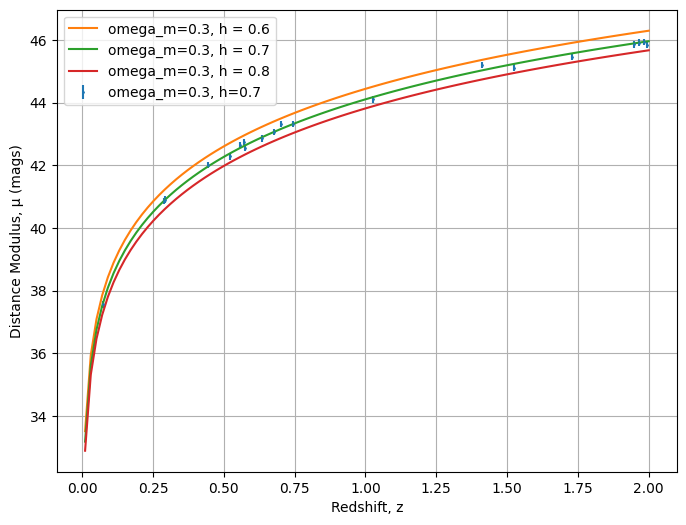

In [5]:
# plot simulated data with theoretical predictions
omega_m_vals=[0.3]
hubble_vals=[0.7]
rmserror = 0.1
simulated_df = simulate_supernovae(0, 2, 20, omega_m_vals, hubble_vals, 0, rmserror)

hubble_vals = [0.6, 0.7, 0.8]
omega_m_vals = [0.3]
theoretical_df=supernova_curves(omega_m_vals, hubble_vals)


fig, ax = plt.subplots(figsize=(8, 6))
    
# scatterplt of actual supernova data
# supernova_df.plot(kind="scatter", x="redshift", y="distance modulus", ax=ax, label="Observed Data", color="blue")
    
# plot simulated data
for col in simulated_df.columns[1:]:
    ax.errorbar(simulated_df["redshift"], simulated_df[col], yerr=rmserror, fmt='o', markersize=1, label=col)

# plot theoretical curves
for col in theoretical_df.columns[1:]:
        ax.plot(theoretical_df["redshift"], theoretical_df[col], label=col)

ax.set_xlabel('Redshift, z')
ax.set_ylabel('Distance Modulus, μ (mags)')
ax.grid(True)
ax.legend()
plt.show()

as expected the points are distributed around the theoretical curve with parametes corresponding to those we simulated.

## <h1  style="text-align: center" class="list-group-item list-group-item-action active">Bayesian Parameter Estimation</h1><a id = "2" ></a>

Recipe: 
1. what is the dataset, X? We think of these as points sampled from random variables defining the observed quantity.
2. what is the theoretical model for this observed quantity and what are the parameters, w, of this model which we wish to estimate?
3. Prior for these parameters? p(w) ("prior belief for these parameters independent of current data being observed")
4. Make probabilistic model for measured data and compute likelihood L(w, X) = p(X | w) ("likelihood of observing data given parameters")
5. compute (un)normalised posterior p(w | X) ~ L(w, X) p(w) (probabilty dist for the parameters given the observed data)
6. marginalise over intermediate/nuisance parameters (parameters we do not estimate but equally we dont know their value so marginalised over them with some prior)
7. sampling from the posterior distribution and producing summary statistics e.g. estimates
8. check validity of priors and model

This example:
1. The data is the supernova dataset, the distance mod, mu, and redshifts, z,  pairs for each supernova. 
2. The target parameters are the matter density omega_m and hubble constant. We assume flat space so only one matter density.
3. The model is the method by which we produce pairs (mu, z). I.e. sampling method for the z values and then the method of generating the mu values i.e. theoretical curves for modulus + noise! The noise is assume to be normally dist.
4. The nuisance parameters are any used in the model which arent h or omega_m. The params determining input distrubution of z values and the parameters for the noise of the mu values. Rather than marginalising over all of these we will *condition* on the redshift values contained in the data. That is we are interested in the relationship between z and mu, so the z values are included as parameters of the model and are in the prior! We will marginalise over the variance of the gaussian noise in mu while the mean is set to 0 (no bias, assuming additional bias would be testing a different theoretical curve! RETURN TO THIS IN VALIDATION). 
5. Compute (log)likelihood and (log)posterior, check normalisation of posterior.
6. Marginalise over variance of noise (or leave this in and sample in a larger space)
7. We then sample the posterior distribution i.e. the distribution in parameter space given the data using various methods and summarise
8. Finally, we check validity of theoretical curves model and also the normally dist. noise and priors (i.e. are redshift values we inputed even representative of the true redshift distribution?). Can also check validity of the various sampling methods.

Firstly the data is 31 data points which represent 31 bins of supernovae. The total dataset is 700 data points. There is a 31 x 31 covariance matrix describing the within-bin variances and the between bin correlations.

By binning the data, we have acces to this covariance data which can be used to model the noise about the theoretical curves assuming gaussian noise.

In [6]:
# load in covariances 
cov_df=load_cov_data("../data/jla_mub_covmatrix.txt")
cov_df.head()
cov_df.shape

(961, 1)

### Log Likelihood and Log Posterior

Since we are assuming a model with gaussian errors (accounting for noise) about the mean value given by the theoretical curve. Then the likelihood p(X|w) is just that for a normal districution roughly N(X,w) ~ exp[- 1/2 (x-mu)^2/var].

We find it easier to work with log probabilities. So we compute the log likelihood. The log-likelihood is then given by the exponent of the normal dist i.e. the chi-squared statistic: the square of the distances of the observed data from the thoeretical value weighted by the covariance matrix which measures the noise of the 700 supernova samples about the average resampled or binned data which only has 31 points.

As such we are using ther sample covariances as an estimate of the population covariance in our model. This is like conditioning on the covariance paramters but with a prior which sets the population covariance to be the sample estimate with probability 1.

Define log likelihood in model.py script of mu data given theoretical curve and some choice of parameters.

In [7]:
# example theoretical model (a curve with no noise) and log likelihood (a single number) for the probability of the data given this model
mu_theory=[dist_mod_func(z, 0.3, 0.7) for z in supernova_df["redshift"]]
model_log_likelihood(supernova_df["distance modulus"], mu_theory, cov_df["covariance"])

np.float64(-16.999878841718306)

Given the likelihood, the posterior is given by multiplying also by the prior and normalising using the total probability of the evidence/data (p(X) without model dependence). We assume uniform priors for the parameters h and omega_m  on the range 0 to 1 so the prior is just multiplying by 1. The evidence drops out of the following algorithms since we are interested in ratios of probailities or (differences of log probabilities).

This is important since we have no easy way to access the probabiliy of the evidence/data p(X) (agnostic to the parameters and/or any model). We could compute this probability of the evidence by marginalising the likelihood over the parameter space but this is still model dependent since we can only marginalise over the parameters we explicity included in the model which should itself be though of as a sub model in some larger parameter space where have condition on the unknown parameters. Fortunately this is not needed. So we can just use the likelihood as the "unnormalised posterior". Normalise at the end manually. For the log posterior normalising means ensuring it is less than 0.

## <h1  style="text-align: center" class="list-group-item list-group-item-action active">MCMC Metropolis-Hastings Sampling of Posterior</h1><a id = "3" ></a>

Define code that carries out the Metropolis-Hastings algorithm for a Monte Carlo Markov Chain method for sampling this posterior dist which in our case is just the likelihood L(X,w)=p(X|w) since we use flat priors. 

This algorithm works by taking a random walk in the parameter space (parameters which determine the liklihood) which is weighted by the liklihood distribution and so in effect samples this distribution. The random walk samples a point at random according to a proposal distribution and accepts the sample and moves to the new point if that point has a higher liklihood. If the new point has a lower liklihood it may still accept the new point with some probability proportional to the difference in log liklihoods.

This random walk spends more time/samples in areas of param space with high liklihood values i.e. explain the data well versus those with lower probabilities. It occasionaly visits a lower prob region. The samples hence reflects the likelihood from which we get the posterior (with flat priors they are the same).

We first choose a distribution for the way in which two new parameters (h, omega_m) are choosen step wise in the random walk. We will use a zero mean 2D normal distribution with no correlations but variances chosen to match the posterior landscape. These variances set the step sizes of the walk. Number of steps is n_steps.

We will use flat priors on [0,1] i.e. a prior which equals 1 on the range [0,1]. This equates to a log prior which is 0 on this range (-inf outside)

Build dataframe with sample chains from the sampling method i.e. the sample chain of omega_m, hubble_const and the evaluated log likelihood at that point in param space.

we also keep the accpeted probability of the metropolis hastings method. This is the proportion of proposed samples that the method considered which it ended up accepting

In [8]:
samples=supernova_metropolis_hastings(supernova_df["distance modulus"], supernova_df["redshift"], cov_df["covariance"], 0.5, 0.5, 10000, 0.01, 0.01, logflatprior, logflatprior)
sample_df=samples[0]
print(accepted_prob:=samples[1])
sample_df.head()

0.5122


,omega_m,hubble const,log post
0,0.500000,0.500000,-731.977788
1,0.490746,0.504846,-694.731459
2,0.494604,0.505010,-690.283841
3,0.494604,0.505010,-690.283841
4,0.494604,0.505010,-690.283841


Accepted probability i.e. chance to make a step in the walk is between 0.1 and 0.5 which is within an allowable range

scatter plot the markov chain samples and their log likelihoods

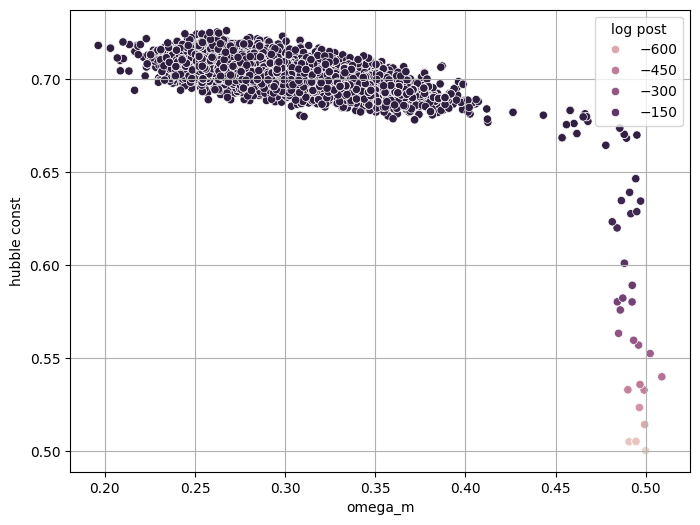

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
    
sns.scatterplot(sample_df, x="omega_m", y="hubble const", hue="log post")

ax.set_xlabel('omega_m')
ax.set_ylabel('hubble const')
ax.grid(True)
plt.show()

We see a 'burn in' due to our initial conditions. The random walk takes a few steps before converging towards and exploring the regions of high probability density. We can see this again using trace plot of the evolution of the random walk in parameter space.

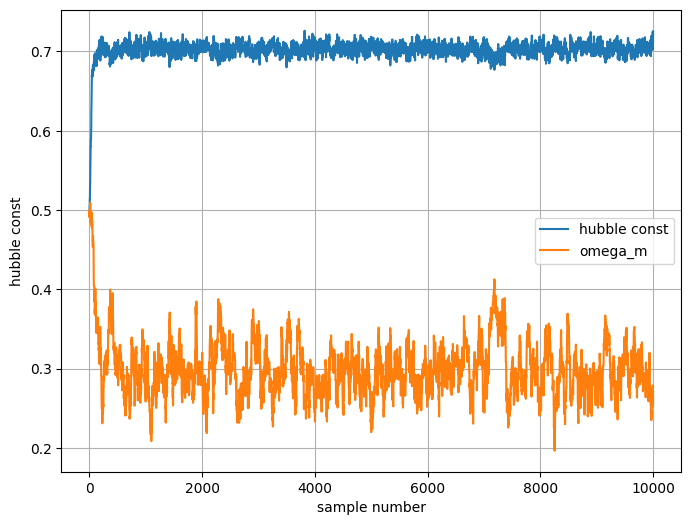

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
    
sns.lineplot(sample_df, x=sample_df.index, y="hubble const", ax=ax, label="hubble const")
sns.lineplot(sample_df,x =sample_df.index, y="omega_m", ax=ax, label="omega_m")

ax.grid(True)
ax.set_xlabel('sample number')
ax.legend()
plt.show()

## <h1  style="text-align: center" class="list-group-item list-group-item-action active">Summary Statistics and Estimates of Parameters</h1><a id = "4" ></a>

We truncate data to drop the burn in initial phase

In [11]:
sample_trunc_df=sample_df.copy()
sample_trunc_df=sample_trunc_df[1000:]

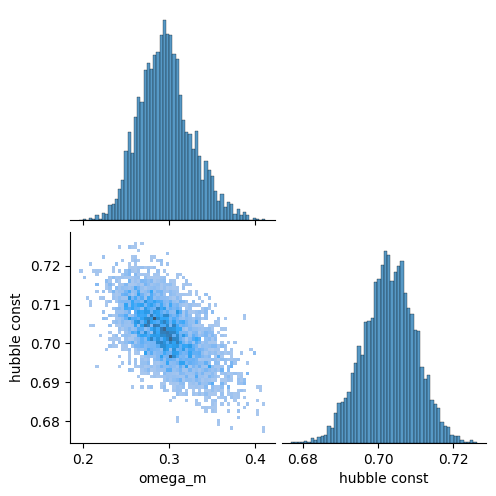

In [12]:
sns.pairplot(sample_trunc_df, vars=["omega_m","hubble const"], corner=True, kind="hist")
plt.show()

mean and median and covariance matrix of this sampled posterior distribution

In [13]:
sample_means = sample_trunc_df.drop(['log post'], axis=1).mean()
sample_medians = sample_trunc_df.drop(['log post'], axis=1).median()
sample_cov_df = sample_trunc_df.drop(['log post'], axis=1).cov()

print(f"Sample Mean:\n{sample_means}")
print(f"Sample Median:\n{sample_medians}")
print(f"Sample Covariance Matrix:\n{sample_cov_df}")

Sample Mean:
omega_m         0.296688
hubble const    0.702948
dtype: float64
Sample Median:
omega_m         0.294928
hubble const    0.703071
dtype: float64
Sample Covariance Matrix:
               omega_m  hubble const
omega_m       0.000959     -0.000127
hubble const -0.000127      0.000049


mode

In [14]:
sample_trunc_df.sort_values(by="log post", ascending=False, inplace=True)
mode=sample_trunc_df.iloc[0, :-1]
print(f"Mode of posterior distribution: {mode}")

Mode of posterior distribution: omega_m         0.294342
hubble const    0.703354
Name: 6122, dtype: float64


find covariance matrix of this sampled posterior distribution

In [15]:
sample_cov_df=sample_trunc_df.drop(['log post'], axis = 1).cov()
sample_cov_df

,omega_m,hubble const
omega_m,0.000959,-0.000127
hubble const,-0.000127,0.000049


## <h1  style="text-align: center" class="list-group-item list-group-item-action active">Try a Different Prior</h1><a id = "5" ></a>

We try a different prior for the Hubble constant. We try priors which are Gaussian. A good prior with with mean 0.738 and st dev 0.024 and a bad prior with mean 0.2 and stdev 0.01. This means that the posterior is no longer simply given by the likelihood on the range [0,1] (flat prior). We can however get the new posterior by weighting the samples by this new prior (this is an example of *importance sampling*). 

In [18]:
h_prior_m=0.2
h_prior_stdev=0.01
gauss_logprior=loggaussprior(h_prior_m, h_prior_stdev)
samples_gauss=supernova_metropolis_hastings(supernova_df["distance modulus"], supernova_df["redshift"], cov_df["covariance"], 0.5, 0.5, 10000, 0.01, 0.01, gauss_logprior, logflatprior)
sample_gauss_df=samples_gauss[0]
print(accepted_prob:=samples_gauss[1])
sample_gauss_df.head()

0.398


,omega_m,hubble const,log post
0,0.500000,0.500000,-1181.977788
1,0.500000,0.500000,-1181.977788
2,0.500000,0.500000,-1181.977788
3,0.495661,0.514301,-1103.409338
4,0.495661,0.514301,-1103.409338


In [19]:
h_prior_m=0.738
h_prior_stdev=0.024
gauss_prior=loggaussprior(h_prior_m, h_prior_stdev)
samples_goodgauss=supernova_metropolis_hastings(supernova_df["distance modulus"], supernova_df["redshift"], cov_df["covariance"], 0.5, 0.5, 10000, 0.01, 0.01, gauss_prior, logflatprior)
sample_goodgauss_df=samples_goodgauss[0]
print(accepted_prob:=samples_goodgauss[1])
sample_goodgauss_df.head()

0.5066


,omega_m,hubble const,log post
0,0.500000,0.500000,-781.147927
1,0.505505,0.508070,-701.004795
2,0.505505,0.508070,-701.004795
3,0.520984,0.514337,-635.093635
4,0.527472,0.530313,-505.192484


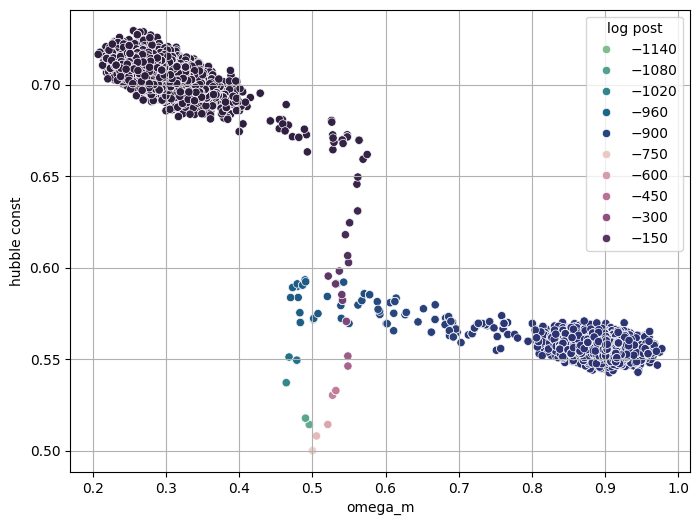

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))
    
sns.scatterplot(sample_gauss_df, x="omega_m", y="hubble const", hue="log post", palette="crest")
sns.scatterplot(sample_goodgauss_df, x="omega_m", y="hubble const", hue="log post")

ax.set_xlabel('omega_m')
ax.set_ylabel('hubble const')
ax.grid(True)
plt.show()

With the prior peaked narrowly at a wrong value for hubble constant we see that the burn in is longer as the prior influences the posterior. However the data is informative and prevails in the end. There is lasting bias however, the settled value for the estimate for the paramters is different to before.

## <h1  style="text-align: center" class="list-group-item list-group-item-action active">Hamiltonian Monte Carlo</h1><a id = "6" ></a>

We test a Hamiltonian Monte Carlo Algorithm to resample the posterior distribution in different manner.

Rather than using the original model_log_liklihood funciton which is a complicated function of the parameters. We will instead use the empirical distribution of the posterior in parameter space which we found using metropolis hastings in previous step.

That is we assume that the log_posterior is given by a bivariate normal distribution in paramter space with means and covariance matrix given by the empirical i.e. sampled distribution.

In [27]:
print(sample_means)
print(sample_cov_df)

omega_m         0.296688
hubble const    0.702948
dtype: float64
               omega_m  hubble const
omega_m       0.000959     -0.000127
hubble const -0.000127      0.000049


calculate the empirical log posterior function and its gradient function

In [28]:
model_log_posterior = lambda x : empirical_log_posterior(x[0], x[1], sample_means, sample_cov_df)
grad_log_posterior = simple_grad_log_posterior(sample_means, sample_cov_df)

# init params
param_df = pd.DataFrame(data=[['omega_m', 0.5],['h', 0.5]], columns=["param_names", "params_init"])

In [29]:
print(model_log_posterior([0.5, 0.5]))
print(grad_log_posterior([0.5, 0.5]))

-510.6154773370992
[ -526.90490272 -5559.84501389]


In [30]:
HMC_sample_df, acceptance_prob = hamiltonian_monte_carlo(model_log_posterior, 
                                                         grad_log_posterior, 
                                                         n_steps=10000, 
                                                         param_df=param_df, 
                                                         leapfrog_step_size=0.0005, 
                                                         leapfrog_steps=5)

print(acceptance_prob)
HMC_sample_df.head(-10)

0.8988


,omega_m,h,log post
0,0.500000,0.500000,-510.615477
1,0.500000,0.500000,-510.615477
2,0.500000,0.500000,-510.615477
3,0.500000,0.500000,-510.615477
4,0.500000,0.500000,-510.615477
...,...,...,...
9986,0.255146,0.708715,-0.901030
9987,0.255146,0.708715,-0.901030
9988,0.255035,0.707948,-0.909464
9989,0.254486,0.707203,-0.957879


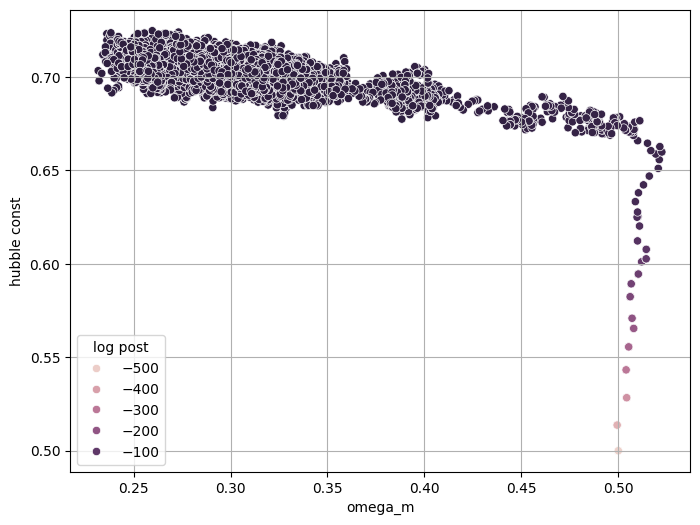

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))
    
sns.scatterplot(HMC_sample_df, x="omega_m", y="h", hue="log post")

ax.set_xlabel('omega_m')
ax.set_ylabel('hubble const')
ax.grid(True)
plt.show()

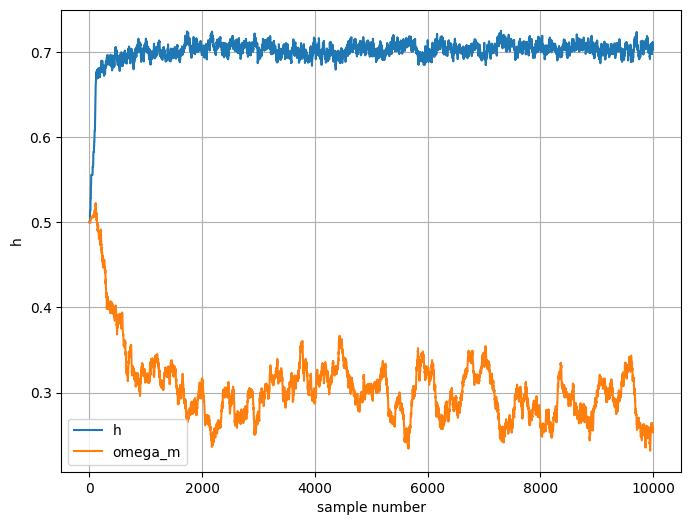

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))
    
sns.lineplot(HMC_sample_df, x=HMC_sample_df.index, y="h", ax=ax, label="h")
sns.lineplot(HMC_sample_df,x =HMC_sample_df.index, y="omega_m", ax=ax, label="omega_m")

ax.grid(True)
ax.set_xlabel('sample number')
ax.legend()
plt.show()

We see that the burn in for the Hamiltonian Monte Carlo is longer. It is also very sensitive to the values of the leapfrog integration stepsize and number of steps

The model estimates and covariances are

In [36]:
HMC_sample_trunc_df=HMC_sample_df.copy()
HMC_sample_trunc_df=HMC_sample_trunc_df[1000:]

In [37]:
HMC_sample_means = HMC_sample_trunc_df.drop(['log post'], axis=1).mean()
HMC_sample_medians = HMC_sample_trunc_df.drop(['log post'], axis=1).median()
HMC_sample_cov_df = HMC_sample_trunc_df.drop(['log post'], axis=1).cov()

print(f"Sample Mean:\n{HMC_sample_means}")
print(f"Sample Median:\n{HMC_sample_medians}")
print(f"Sample Covariance Matrix:\n{HMC_sample_cov_df}")

Sample Mean:
omega_m    0.297000
h          0.703177
dtype: float64
Sample Median:
omega_m    0.298236
h          0.703320
dtype: float64
Sample Covariance Matrix:
          omega_m         h
omega_m  0.000672 -0.000088
h       -0.000088  0.000044
